# LOAD PACKAGES

In [2]:
# Load packages
import numpy as np  
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import re
#import tensorflow as tf
import seaborn as sns
sns.set_style('whitegrid')

from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
print "Read in packages from numpy, pandas, sklearn, seaborn & matplotlib"

Read in packages from numpy, pandas, sklearn, seaborn & matplotlib


# PICKLING

In [3]:
from six.moves import cPickle as pickle
pickle_file = 'train_set.pickle'

## Read from Pickle

In [4]:
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    ptrain_set = save['train_set']
    del save  # hint to help gc free up memory
    print('Loaded ptrain_set', ptrain_set.shape)
    
f.close()

('Loaded ptrain_set', (190080, 18))


# TRAIN / VALIDATE / TEST SPLIT

In [5]:
# Split train / test data - for coarse training
train_days     = range(2,16)
train_times    = range(39,140,4)
validate_days  = [16, 18, 20]
validate_times = range(39,140,4)
test_days      = [17, 19, 21]
test_times     = range(40,141,4)

X_train     = ptrain_set[(ptrain_set['num_day'].isin(train_days))    & (ptrain_set['time_slot'].isin(train_times))]
X_validate  = ptrain_set[(ptrain_set['num_day'].isin(validate_days)) & (ptrain_set['time_slot'].isin(validate_times))]
X_test      = ptrain_set[(ptrain_set['num_day'].isin(test_days))     & (ptrain_set['time_slot'].isin(test_times))]

print "Shape of X_train, X_validate, X_test:", X_train.shape, X_validate.shape, X_test.shape, "\n\n"

print "X_train\n"
print X_train.head(5), "\n\n"
print X_train.describe(), "\n\n"

print "X_validate\n"
print X_validate.head(5), "\n\n"
print X_validate.describe(), "\n\n"

print "X_test\n"
print X_test.head(5), "\n\n"
print X_test.describe(), "\n\n"

Shape of X_train, X_validate, X_test: (24024, 18) (5148, 18) (5148, 18) 


X_train

       district_id  num_day  time_slot  week_day  demand  demand_t-1  \
11105            1        2         39         5      14          27   
15718            1        2         43         5      55          28   
16478            1        2         47         5     100          66   
11843            1        2         51         5     115         121   
12568            1        2         55         5     106         106   

       demand_t-2  demand_t-3  supply  supply_t-1  supply_t-2  supply_t-3  \
11105          18          12      12          20          17           6   
15718          36          22      53          28          35          22   
16478          52          60      96          66          52          59   
11843          91          78     114         117          91          78   
12568         137         112     102         101         134         110   

       gap  weather 

# SCORES

In [6]:
# Calculate the MAPE Score
def mape_score(exp, pred):
    mape = 0.0
    n = 66.0
    q = 43.0
    for gap, gapX in zip(exp, pred):
        if gap > 0:
            mape += 1.0 * abs((gap-gapX)/gap)
    return (mape/(n*q))

# Evaluate Scores & Present as a table - Mean Squared, R2, MAPE
def eval_score(y_train, y_pred_train, y_validate, y_pred_validate, y_test, y_pred_test):
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_validate = metrics.mean_squared_error(y_validate, y_pred_validate)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_validate = metrics.r2_score(y_validate, y_pred_validate)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    mpscore_train    = mape_score(y_train,    y_pred_train)
    mpscore_validate = mape_score(y_validate, y_pred_validate)
    mpscore_test     = mape_score(y_test,     y_pred_test)


    sets_list = ["TRAIN", "VALIDATE", "TEST"]

    m2_scores = [m2score_train, m2score_validate, m2score_test]
    r2_scores = [r2score_train, r2score_validate, r2score_test]
    mp_scores = [mpscore_train, mpscore_validate, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'


    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.2f}\t\t{2:.2f}\t\t{3:.2f}' .format(s, m, r, mp)

# DEMAND, SUPPLY PREDICTIONS & GAP FORECASTING

In [7]:
# Use fit function to generate predictions for train, validate and test sets
# Evaluate scores and print results
# Used for demand, supply predictions
def predict_score(train_set, validate_set, test_set, predictors, exp_col, fitfunc, *fitargs):

    # Generate dataframe for train, validate & test
    Xtrain_df    = train_set[predictors]
    Xvalidate_df = validate_set[predictors]
    Xtest_df     = test_set[predictors]
    
    # Generate predictions for train, validate & test
    y_pred_train    = fitfunc(Xtrain_df,    *fitargs)
    y_pred_validate = fitfunc(Xvalidate_df, *fitargs)
    y_pred_test     = fitfunc(Xtest_df,     *fitargs)

    # Extract expected train, validated & test values
    y_train    = train_set[exp_col]
    y_validate = validate_set[exp_col]
    y_test     = test_set[exp_col]

    # Evaluate scores and print results
    eval_score(y_train, y_pred_train, y_validate, y_pred_validate, y_test, y_pred_test)
    
    return(y_pred_train, y_pred_validate, y_pred_test)

In [8]:
# Generate Demand Supply Gap Metrics based on provided fit functions
# Assumes expected values for demand, supply, gap are in namesake columns
def gap_forecast(**kwargs):
    
    X_train      = kwargs["train_set"]
    X_validate   = kwargs["validate_set"]
    X_test       = kwargs["test_set"]
    r_predictors = kwargs["demand_predictors"]
    a_predictors = kwargs["supply_predictors"]
    r_fitfunc    = kwargs["rfit_func"]
    r_fitargs    = kwargs["rfit_args"]
    a_fitfunc    = kwargs["afit_func"]
    a_fitargs    = kwargs["afit_args"]
    
    print "\n\nDEMAND FORECASTING"
    print     "=================="

    ry_pred_train, ry_pred_validate, ry_pred_test = predict_score(X_train, X_validate, X_test, 
                                                                  r_predictors, 'demand', 
                                                                  r_fitfunc, *r_fitargs)

    print "\n\nSUPPLY FORECASTING"
    print     "=================="

    ay_pred_train, ay_pred_validate, ay_pred_test = predict_score(X_train, X_validate, X_test,
                                                                  a_predictors, 'supply', 
                                                                  a_fitfunc, *a_fitargs)

    print "\n\nGAP FORECASTING"
    print     "==============="

    gapy_pred_train    = [r - a for r, a in zip(ry_pred_train,    ay_pred_train)]
    gapy_pred_validate = [r - a for r, a in zip(ry_pred_validate, ay_pred_validate)]
    gapy_pred_test     = [r - a for r, a in zip(ry_pred_test,     ay_pred_test)]

    gapy_train    = X_train['gap']
    gapy_validate = X_validate['gap']
    gapy_test     = X_test['gap']

    eval_score(gapy_train, gapy_pred_train, gapy_validate, gapy_pred_validate, gapy_test, gapy_pred_test)
    
    return

In [9]:
print(__doc__)

from sklearn import cross_validation
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


# LINEAR REGRESSION

In [10]:
X_train.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_cluster', 'congestion'], dtype=object)

In [11]:
import warnings
warnings.filterwarnings('ignore')

r_predictors = ['time_slot', 'week_day', 'demand_t-1', 'demand_t-2', 'demand_t-3', 
                'poi_cluster', 'congestion'] 

a_predictors = ['time_slot', 'week_day', 'supply_t-1', 'supply_t-2', 'supply_t-3', 
                'poi_cluster', 'congestion'] 

rX_train = []
ry_train = []
aX_train = []
ay_train = []

rX_test = []
ry_test = []
aX_test = []
ay_test = []

# Normalize features - both training & test (withheld & final)
r_scaler = StandardScaler().fit(ptrain_set[r_predictors])
a_scaler = StandardScaler().fit(ptrain_set[a_predictors])

d_scaler = StandardScaler().fit(ptrain_set['demand'])
s_scaler = StandardScaler().fit(ptrain_set['supply'])

# Input Samples and Target Values for Demand(r), Supply(a)
# Demand
rX_train  = r_scaler.transform(X_train[r_predictors])
ry_train  = d_scaler.transform(X_train['demand'])

rX_test = r_scaler.transform(X_test[r_predictors])
ry_test = d_scaler.transform(X_test['demand'])

# Supply
aX_train = a_scaler.transform(X_train[a_predictors])
ay_train = s_scaler.transform(X_train['supply'])

aX_test = a_scaler.transform(X_test[a_predictors])
ay_test = s_scaler.transform(X_test['supply'])

In [12]:
# Fit Linear Regressor for Demand & Supply Predictors
# Initialize the algorithm
# Linear regression defaults to R^2 as score
from sklearn.linear_model import LinearRegression
alg = LinearRegression()

# Create training set of increasing sizes
train_size_set = [4000, 8000, 12000, 16000, 20000, 24024]

Xr_train_set = []
yr_train_set = []
Xa_train_set = []
ya_train_set = []


for size in train_size_set: 
    Xr_train_set.append(rX_train[:size])
    yr_train_set.append(ry_train[:size])
    Xa_train_set.append(aX_train[:size])
    ya_train_set.append(ay_train[:size])

Xr_test = rX_test
yr_test = ry_test
Xa_test = aX_test
ya_test = ay_test

In [13]:
# Fit logistic regression for selected sizes
# Train Demand Forecaster
print ("\nTraining Demand Forecaster\n")

for train_size, Xr_train, yr_train in zip(train_size_set, Xr_train_set, yr_train_set):
    clf = alg.fit(Xr_train, yr_train)
    
    # Scores
    train_score = clf.score(Xr_train, yr_train)
    test_score  = clf.score(Xr_test, yr_test)
    print ("Train Size: {} Train Score: {} Test Score: {}" .format(train_size, train_score, test_score))


Training Demand Forecaster

Train Size: 4000 Train Score: 0.951067016421 Test Score: 0.96687058269
Train Size: 8000 Train Score: 0.945311587547 Test Score: 0.965808266064
Train Size: 12000 Train Score: 0.948376770724 Test Score: 0.965115872519
Train Size: 16000 Train Score: 0.949799060991 Test Score: 0.965549883742
Train Size: 20000 Train Score: 0.958453096718 Test Score: 0.965485185387
Train Size: 24024 Train Score: 0.959755456836 Test Score: 0.965546371127


In [14]:
# Train Supply Forecaster
print ("\nTraining Supply Forecaster\n")

for train_size, Xa_train, ya_train in zip(train_size_set, Xa_train_set, ya_train_set):
    clf = alg.fit(Xa_train, ya_train)
    
    # Scores
    train_score = clf.score(Xa_train, ya_train)
    test_score  = clf.score(Xa_test, ya_test)
    print ("Train Size: {} Train Score: {} Test Score: {}" .format(train_size, train_score, test_score))


Training Supply Forecaster

Train Size: 4000 Train Score: 0.96960013005 Test Score: 0.979130178555
Train Size: 8000 Train Score: 0.959423988936 Test Score: 0.979067759751
Train Size: 12000 Train Score: 0.964145312357 Test Score: 0.979224167246
Train Size: 16000 Train Score: 0.964291311531 Test Score: 0.979316123053
Train Size: 20000 Train Score: 0.973906565307 Test Score: 0.979352186172
Train Size: 24024 Train Score: 0.9748194508 Test Score: 0.979365861204


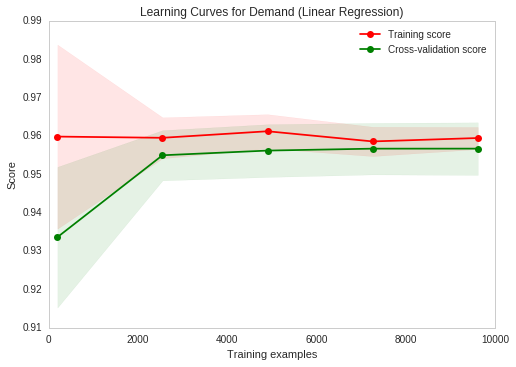

In [15]:
# Plot learning curve
X, y = rX_train, ry_train

title = "Learning Curves for Demand (Linear Regression)"

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=5,
                                   test_size=0.2, random_state=0)

estimator = LinearRegression()
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=6, train_sizes=np.linspace(.01, 0.5, 5))

plt.show()

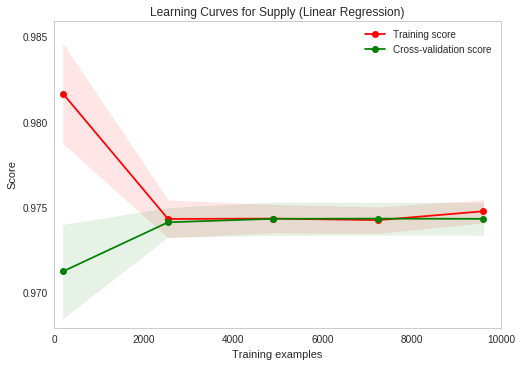

In [16]:
# Plot learning curve
X, y = aX_train, ay_train

title = "Learning Curves for Supply (Linear Regression)"

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=5,
                                   test_size=0.2, random_state=0)

estimator = LinearRegression()
plot_learning_curve(estimator, title, X, y, cv=cv, train_sizes=np.linspace(.01, 0.5, 5))

plt.show()

In [ ]:
# Set arguments for gap forecasting function
kwargs = {"train_set": X_train, "validate_set": X_validate, "test_set": X_test, 
          "demand_predictors": r_predictors, "supply_predictors": a_predictors,
          "rfit_func": simple_average, "rfit_args": r_predictors,
          "afit_func": simple_average, "afit_args": a_predictors}

gap_forecastn(**kwargs)

# BENCHMARK - SIMPLE AVERAGE

In [111]:
# Return simple average of previous 3 time slots
def simple_average(df, t1, t2, t3):
    return df.apply(lambda r: ((r[t1] + r[t2] + r[t3]) / 3.0), axis=1)

# Define list of predictors for demand, supply
r_predictors = ['district_id', 'num_day', 'time_slot', 'demand_t-1', 'demand_t-2', 'demand_t-3'] 
a_predictors = ['district_id', 'num_day', 'time_slot', 'supply_t-1', 'supply_t-2', 'supply_t-3']

# Set arguments for gap forecasting function
kwargs = {"train_set": X_train, "validate_set": X_validate, "test_set": X_test, 
          "demand_predictors": r_predictors, "supply_predictors": a_predictors,
          "rfit_func": simple_average, "rfit_args": ['demand_t-1','demand_t-2','demand_t-3'],
          "afit_func": simple_average, "afit_args": ['supply_t-1','supply_t-2','supply_t-3']}

gap_forecast(**kwargs)



DEMAND FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	784.82		0.93		3.24
VALIDATE  	1055.78		0.94		0.66
TEST      	888.39		0.94		0.69


SUPPLY FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	252.86		0.96		2.90
VALIDATE  	262.72		0.97		0.60
TEST      	241.56		0.97		0.63


GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	508.04		0.59		4.40
VALIDATE  	776.12		0.77		0.98
TEST      	639.48		0.77		0.89


# FEATURE IMPORTANCE

In [123]:
# Assess Feature importance
r_predictors = ['district_id', 'num_day', 'time_slot', 'week_day', 'demand_t-1', 'demand_t-2', 'demand_t-3', 
                'weather', 'temperature', 'pollution'] 

a_predictors = ['district_id', 'num_day', 'time_slot', 'week_day', 'supply_t-1', 'supply_t-2', 'supply_t-3', 
                'weather', 'temperature', 'pollution'] 

# Normalize features - both training & test (withheld & final)
#scaler = StandardScaler().fit(train_set)
#train_set_trans = scaler.transform(train_set)
#print ("Transformed training set")

# Scoring Metric - MSE
print ("Use MSE as the score function")

# Input Samples and Target Values for Demand(r), Supply(a)
r_train  = train_set[r_predictors]
ry_train = train_set['demand']

a_train  = train_set[a_predictors]
ay_train = train_set['supply']

# Fit Random Forest Regressor for Demand & Supply Predictors
alg = RandomForestRegressor(random_state=1, n_estimators=1000, min_samples_split=50, min_samples_leaf=1)
r_clf = alg.fit(r_train, ry_train)
a_clf = alg.fit(a_train, ay_train)

Use MSE as the score function


 1) demand_t-1                     0.989196
 2) time_slot                      0.004408
 3) demand_t-2                     0.002317
 4) demand_t-3                     0.002096
 5) district_id                    0.000739
 6) pollution                      0.000505
 7) num_day                        0.000269
 8) temperature                    0.000202
 9) week_day                       0.000197
10) weather                        0.000071


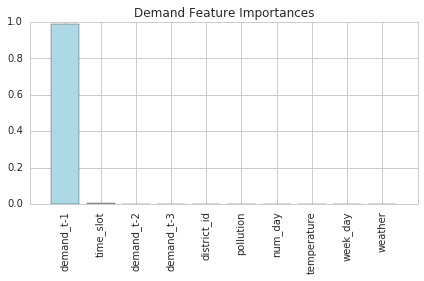

In [124]:
# Feature importances - Demand (r)
importances = r_clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_labels = r_predictors
for f in range(r_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                             feature_labels[indices[f]], 
                             importances[indices[f]]))

labels_reordered = [feature_labels[i] for i in indices]
    
plt.title('Demand Feature Importances')
plt.bar(range(r_train.shape[1]), 
         importances[indices],
         color='lightblue', 
         align='center')
plt.xticks(range(r_train.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, r_train.shape[1]])
plt.tight_layout()
plt.show()

 1) supply_t-1                     0.989196
 2) time_slot                      0.004408
 3) supply_t-2                     0.002317
 4) supply_t-3                     0.002096
 5) district_id                    0.000739
 6) pollution                      0.000505
 7) num_day                        0.000269
 8) temperature                    0.000202
 9) week_day                       0.000197
10) weather                        0.000071


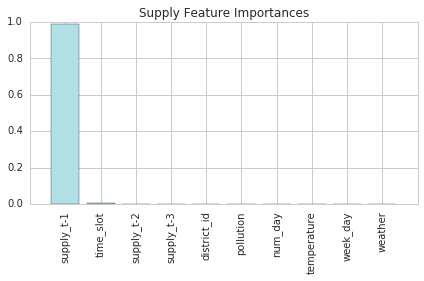

In [125]:
# Feature importances - Supply (a)
importances = a_clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_labels = a_predictors
for f in range(a_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                             feature_labels[indices[f]], 
                             importances[indices[f]]))

labels_reordered = [feature_labels[i] for i in indices]
    
plt.title('Supply Feature Importances')
plt.bar(range(a_train.shape[1]), 
         importances[indices],
         color='powderblue', 
         align='center')
plt.xticks(range(a_train.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, a_train.shape[1]])
plt.tight_layout()
plt.show()

# PLOTS

In [106]:
print [int(x) for x in ry_train[:5]]
print [int(x) for x in ay_train[:5]]


print [int(x) for x in ry_pred_train[:5]]
print [int(x) for x in ay_pred_train[:5]]

print [int(x) for x in gapy_pred_train[:5]]
print [x for x in gapy_train[:5]]

[14, 55, 100, 115, 106]
[12, 53, 96, 114, 102]
[19, 28, 59, 96, 118]
[14, 28, 59, 95, 115]
[4, 0, 0, 1, 3]
[2, 2, 4, 1, 4]


In [ ]:
x, y = pd.Series(gapy_test, name="Actual"), pd.Series(gapy_pred_test, name="Predicted")

f, ax = plt.subplots(figsize=(8, 8))
f.suptitle('Test Data Regplot', fontsize=20)
sns.regplot(x=x, y=y, ax=ax, color="g")

In [ ]:
# Plot training data: d, s, g
dplot = []
splot = []
gplot = []

trange   = range(1,21*144)
pltrange = max(trange)-min(trange)

for t in trange:
    dplot.append(d_train[(20,t)])
    splot.append(s_train[(20,t)])
    gplot.append(g_train[(20,t)])

f, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(20,15))
plt.xlim(0, pltrange)
ax1.grid(True)
#ax1.set_yticks(np.arange(0,160,20))
ax1.set_xticks(np.arange(0, pltrange,144))
    
sns.tsplot(data=dplot, ax=ax1, value="demand")
sns.tsplot(data=splot, ax=ax2, value="supply")
sns.tsplot(data=gplot, ax=ax3, value="gap")

In [ ]:
d_test = {}
s_test = {}
g_test = {}
d_test, s_test, g_test = demand_supply(order_test)

# Plot a distribution plot
dist = range(15,30)
time = range(21*144,31*144)

dplot = []
splot = []
gplot = []
for t in range(21*144,31*144):
    dplot.append(d[(20,t)])
    splot.append(s[(20,t)])
    gplot.append(g[(20,t)])

f, (axis1,axis2,axis3) = plt.subplots(3,1, sharex=False, figsize=(20,15))

sns.distplot(dplot, hist=False, color="g", kde_kws={"shade": True}, ax=axis1)
sns.distplot(splot, hist=False, color="b", kde_kws={"shade": True}, ax=axis2)
sns.distplot(gplot, hist=False, color="r", kde_kws={"shade": True}, ax=axis3)

In [ ]:
data = {'demand': dplot, 'gap': gplot}
df = pd.DataFrame(data, columns=['demand', 'gap'])

grid = sns.JointGrid(x='demand', y='gap', data=df, size=15, ratio=4)
grid = grid.plot(sns.regplot, sns.distplot)

In [ ]:
#plot test data
dplot = []
splot = []
gplot = []

trange   = range(23*144,31*144)
pltrange = max(trange)-min(trange)

for t in trange:
    dplot.append(d[(20,t)])
    splot.append(s[(20,t)])
    gplot.append(g[(20,t)])
    
f, (axis1,axis2,axis3) = plt.subplots(3,1, sharex=True, figsize=(20,15))

sns.tsplot(data=dplot, ax=axis1, value="demand")
sns.tsplot(data=splot, ax=axis2, value="supply")
sns.tsplot(data=gplot, ax=axis3, value="gap")

plt.xlim(0, pltrange)

axis1.grid(True)

#axis1.set_yticks(np.arange(0,160,20))
axis1.set_xticks(np.arange(0, pltrange,1))

# REVIEW INPUT FEATURES

In [26]:
# Review input features (ORDER, POI, TRAFFIC, WEATHER) for original training set - Part 1
names = ['ORDER', 'POI', 'TRAFFIC', 'WEATHER']
features = [order_train, poi_train, traffic_train, weather_train]

for name, feature in zip(names, features):
    print "\n\n-----------------------"
    print "{} TRAIN INFORMATION" .format(str.upper(name))
    print "-----------------------"
    print "Shape of training set:", feature.shape, "\n\n"
    print "Column Headers:", list(feature.columns.values), "\n\n"
    print feature.dtypes, "\n\n"
    print feature.head(5), "\n\n"
    print feature.describe(), "\n\n"
    
# Review input features for train set - Part 2
missing_values = []
nonumeric_values = []

names = ['ORDER', 'POI', 'TRAFFIC', 'WEATHER']
features = [order_train, poi_train, traffic_train, weather_train]

print ("TRAIN SET INFORMATION")
print ("========================\n")

for name,feature in zip(names,features):
    
    print "\n-----------------------"
    print "{} TRAIN INFORMATION" .format(name)
    print "-----------------------\n"
    missing_values = []
    nonumeric_values = []
    
    for column in feature:
        
        # Find all the unique feature values
        uniq = feature[column].unique()
        print ("'{}' has {} unique values" .format(column,uniq.size))
        if (uniq.size > 25):
            print("~~Listing up to 25 unique values~~")
        print (uniq[0:24])
        print ("\n-----------------------------------------------------------------------\n")
            
        # Find features with missing values
        if (True in pd.isnull(uniq)):
            s = "{} has {} missing" .format(column, pd.isnull(feature[column]).sum())
            missing_values.append(s)
    
        # Find features with non-numeric values
        for i in range (1, np.prod(uniq.shape)):
            
            if (re.match('nan', str(uniq[i]))):
                break
            
            if not (re.search('(^\d+\.?\d*$)|(^\d*\.?\d+$)', str(uniq[i]))):
                nonumeric_values.append(column)
                break
  
    print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
    print ("{} Features with missing values:\n{}\n\n" .format(name, missing_values))
    print ("{} Features with non-numeric values:\n{}" .format(name, nonumeric_values))
    print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")



-----------------------
ORDER TRAIN INFORMATION
-----------------------
Shape of training set: (8540614, 11) 


Column Headers: ['Time', 'order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash', 'Price', 'num_day', 'time_slot', 'week_day', 'district_id'] 


Time                   datetime64[ns]
order_id                       object
driver_id                      object
passenger_id                   object
start_district_hash            object
dest_district_hash             object
Price                         float64
num_day                         int32
time_slot                       int64
week_day                        int64
district_id                    object
dtype: object 


                 Time                          order_id  \
0 2016-01-01 13:37:23  97ebd0c6680f7c0535dbfdead6e51b4b   
1 2016-01-01 09:47:54  92c3ac9251cc9b5aab90b114a1e363be   
2 2016-01-01 18:24:02  abeefc3e2aec952468e2fd42a1649640   
3 2016-01-01 22:13:27  cb31d0be64cda3cc66

In [ ]:
## sort in-place from highest to lowest
z.sort(key=lambda x: int(x[1]), reverse=True) 

# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
poi_type = zip(*z)[0]
count = zip(*z)[1]
x_pos = np.arange(len(poi_type)) 

plt.bar(x_pos, count,align='center')
plt.xticks(x_pos, poi_type) 
plt.ylabel('POI Count')
plt.xlabel('POI Type')
plt.show()